
# Retail Forecasting – Production-Oriented EDA (Monthly Store × Product)

**Dataset**: `ds_assortiment_dataset.csv`  
**Target**: `volume` (monthly sales volume)  
**Series keys** (proxy for `(store_id, product_id)`): `agency` × `sku`  
**Time range**: 2013-01-01 → 2017-12-01 (monthly starts)

This notebook is designed to be the **single notebook** of the project:
- every chart/stat has a modeling/production decision behind it,
- conclusions are summarized at the end for copy/paste into the README.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Display options (keep it readable during interviews)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

PATH = "../data/ds_assortiment_dataset.csv"

df = pd.read_csv(PATH)
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# ---- core semantic mapping (adapt if your real IDs are named differently) ----
STORE_COL = "agency"
PRODUCT_COL = "sku"
DATE_COL = "date"
TARGET_COL = "volume"

df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")

assert df[STORE_COL].notna().all(), "Unexpected missing store ids"
assert df[PRODUCT_COL].notna().all(), "Unexpected missing product ids"

df["month"] = df[DATE_COL].dt.month
df["year"] = df[DATE_COL].dt.year

df.head()


,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,easter_day,good_friday,new_year,christmas,labor_day,independence_day,revolution_day_memorial,regional_games,fifa_u_17_world_cup,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,month,year
0,Agency_22,SKU_01,52.2720,2013-01-01,492612703,718394219,25.845238,1168.903668,1069.166193,99.737475,48151,132110,0,0,1,0,0,0,0,0,0,0,0,0,8.532566,0,1,2013
1,Agency_37,SKU_04,0.0000,2013-01-01,492612703,718394219,26.505000,1852.273642,1611.466298,240.807344,32769,96761,0,0,1,0,0,0,0,0,0,0,0,0,13.000635,5,1,2013
2,Agency_59,SKU_03,812.9214,2013-01-01,492612703,718394219,22.219737,1270.795012,1197.184260,73.610752,1219986,218902,0,0,1,0,0,0,0,0,0,0,0,0,5.792496,9,1,2013
3,Agency_11,SKU_01,316.4400,2013-01-01,492612703,718394219,25.360000,1176.155397,1082.757488,93.397909,135561,100461,0,0,1,0,0,0,0,0,0,0,0,0,7.940950,14,1,2013
4,Agency_05,SKU_05,420.9093,2013-01-01,492612703,718394219,24.079012,1327.003396,1207.822992,119.180404,3044268,182944,0,0,1,0,0,0,0,0,0,0,0,0,8.981168,22,1,2013



## 1) Global data description (what we are *really* dealing with)

We need to validate:
- shape, columns & dtypes
- cardinality of identifiers
- **true** temporal granularity (monthly strict? missing months?)


In [2]:


n_rows, n_cols = df.shape
print("Rows:", n_rows, " | Columns:", n_cols)

display(df.dtypes.to_frame("dtype"))

n_stores = df[STORE_COL].nunique(dropna=True)
n_products = df[PRODUCT_COL].nunique(dropna=True)
print("\nUnique stores:", n_stores)
print("Unique products:", n_products)

date_min, date_max = df[DATE_COL].min(), df[DATE_COL].max()
print("\nDate range:", date_min.date(), "→", date_max.date())

# monthly strictness (do we always observe the first day of month?)
month_start_ratio = (df[DATE_COL].dt.day == 1).mean()
print("\nMonth-start ratio (date day==1):", round(month_start_ratio, 4))

unique_dates = np.sort(df[DATE_COL].dropna().unique())
# Use pd.to_datetime to ensure we have a DatetimeIndex/Series, then diff to get day gaps.
# This avoids calling `to_series()` on a plain Series and is robust to string / numpy datetime inputs.
diff_days = pd.to_datetime(unique_dates).to_series().diff().dt.days.dropna()
print("\nUnique months:", len(unique_dates))
display(diff_days.describe())


Rows: 21000  | Columns: 28


,dtype
agency,object
sku,object
volume,float64
date,datetime64[ns]
industry_volume,int64
soda_volume,int64
avg_max_temp,float64
price_regular,float64
price_actual,float64
discount,float64



Unique stores: 58
Unique products: 25

Date range: 2013-01-01 → 2017-12-01

Month-start ratio (date day==1): 1.0

Unique months: 60


count    59.000000
mean     30.423729
std       0.834667
min      28.000000
25%      30.000000
50%      31.000000
75%      31.000000
max      31.000000
dtype: float64


## 2) Time series structure (how many series, how long, are there holes?)

For production forecasting per (store, product), we must know:
- number of unique series
- length distribution
- continuity (missing months inside a series)
- whether some series are too short for a 4-month horizon


Number of series (STORE × PRODUCT present in data): 350


count    350.0
mean      60.0
std        0.0
min       60.0
1%        60.0
5%        60.0
10%       60.0
25%       60.0
50%       60.0
75%       60.0
90%       60.0
95%       60.0
99%       60.0
max       60.0
Name: n_months, dtype: float64

Series with < 4 months: 0 (0.00%)
Series with < 8 months: 0 (0.00%)
Series with < 12 months: 0 (0.00%)


/tmp/ipykernel_11037/2740367832.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_per_series = df.groupby(series_keys).apply(missing_months).rename("n_missing_months")


count    350.0
mean       0.0
std        0.0
min        0.0
50%        0.0
75%        0.0
90%        0.0
95%        0.0
99%        0.0
max        0.0
Name: n_missing_months, dtype: float64

Series with any missing months: 0 (0.00%)


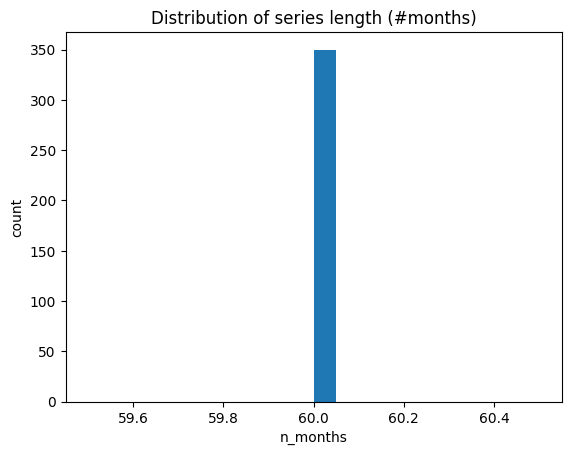

In [3]:

series_keys = [STORE_COL, PRODUCT_COL]

n_series = df.groupby(series_keys).ngroups
print("Number of series (STORE × PRODUCT present in data):", n_series)

series_len = df.groupby(series_keys)[DATE_COL].nunique().rename("n_months")
display(series_len.describe(percentiles=[.01,.05,.1,.25,.5,.75,.9,.95,.99]))

# "too short" depends on your modeling strategy.
# We compute a few useful thresholds to support decisions:
for thr in [4, 8, 12]:
    print(f"Series with < {thr} months:", int((series_len < thr).sum()), f"({(series_len < thr).mean():.2%})")

# continuity vs global calendar
calendar = pd.date_range(df[DATE_COL].min(), df[DATE_COL].max(), freq="MS")

def missing_months(g):
    g_months = set(pd.to_datetime(g[DATE_COL]).dt.to_period("M"))
    cal_months = set(calendar.to_period("M"))
    return len(cal_months - g_months)

missing_per_series = df.groupby(series_keys).apply(missing_months).rename("n_missing_months")
display(missing_per_series.describe(percentiles=[.5,.75,.9,.95,.99]))
print("Series with any missing months:", int((missing_per_series > 0).sum()), f"({(missing_per_series > 0).mean():.2%})")

# quick view of length distribution (should be tight if complete panel)
plt.figure()
plt.hist(series_len.values, bins=20)
plt.title("Distribution of series length (#months)")
plt.xlabel("n_months")
plt.ylabel("count")
plt.show()



## 3) Target analysis (`volume`)

Forecast quality and metric choice are strongly impacted by:
- skewness/heavy tails (outliers)
- zeros (intermittent demand)
- long zero streaks (dormant products/stores)
- abnormal spikes (promotions, stock-outs recovery, data issues)


count    21000.000000
mean      1492.403982
std       2711.496882
min          0.000000
1%           0.000000
5%           0.000000
10%          0.000000
25%          8.272388
50%        158.436000
75%       1774.793475
90%       4794.174000
95%       7526.071800
99%      12671.898225
max      22526.610000
Name: volume, dtype: float64

Skewness: 2.650331258967538
Global zero rate: 0.12147619047619047


count    350.000000
mean       0.121476
std        0.255823
min        0.000000
50%        0.000000
75%        0.033333
90%        0.651667
95%        0.750000
99%        0.850000
max        0.883333
Name: is_zero, dtype: float64

/tmp/ipykernel_11037/621574579.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_zero_run = df.groupby(series_keys).apply(max_zero_streak).rename("max_zero_streak")


count    350.000000
mean       6.402857
std       14.200185
min        0.000000
50%        0.000000
75%        1.000000
90%       39.000000
95%       42.550000
99%       47.000000
max       50.000000
Name: max_zero_streak, dtype: float64

Series with >= 12 consecutive zero months: 54
Series with >= 24 consecutive zero months: 49


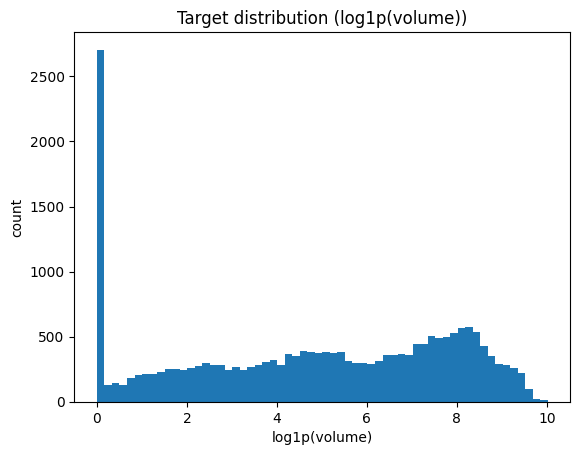

Series with spikes (IQR rule): 72
Total spike points flagged: 289


/tmp/ipykernel_11037/621574579.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spike_df = df.groupby(series_keys, sort=False).apply(spike_stats)


,,iqr,thresh,n_spikes,max,median
agency,sku,,,,,
Agency_40,SKU_04,25.336350,101.728800,14.0,900.22350,1.66140
Agency_33,SKU_04,3.578400,15.144300,14.0,56.61540,1.30995
Agency_36,SKU_04,0.191700,0.766800,14.0,16.86960,0.00000
Agency_50,SKU_17,0.053325,0.213300,14.0,15.54465,0.00000
Agency_59,SKU_17,0.053250,0.213000,14.0,14.35620,0.00000
Agency_26,SKU_02,0.081000,0.324000,14.0,5.50800,0.00000
Agency_35,SKU_32,0.015975,0.063900,14.0,2.55600,0.00000
Agency_10,SKU_23,0.585000,2.340000,11.0,6.12000,0.00000
Agency_34,SKU_04,2.875500,11.805525,10.0,40.70430,1.24605


In [4]:

from scipy.stats import skew

y = df[TARGET_COL].astype(float)

desc = y.describe(percentiles=[.01,.05,.1,.25,.5,.75,.9,.95,.99])
display(desc)

print("Skewness:", float(skew(y, nan_policy='omit')))
print("Global zero rate:", float((y == 0).mean()))

# Per-series zero rate
zero_ratio_series = df.assign(is_zero=(y == 0)).groupby(series_keys)["is_zero"].mean()
display(zero_ratio_series.describe(percentiles=[.5,.75,.9,.95,.99]))

# Max consecutive zero streak per series (intermittency severity)
def max_zero_streak(g):
    z = (g.sort_values(DATE_COL)[TARGET_COL].values == 0).astype(int)
    max_run, run = 0, 0
    for v in z:
        if v == 1:
            run += 1
            max_run = max(max_run, run)
        else:
            run = 0
    return max_run

max_zero_run = df.groupby(series_keys).apply(max_zero_streak).rename("max_zero_streak")
display(max_zero_run.describe(percentiles=[.5,.75,.9,.95,.99]))
print("Series with >= 12 consecutive zero months:", int((max_zero_run >= 12).sum()))
print("Series with >= 24 consecutive zero months:", int((max_zero_run >= 24).sum()))

# Plot: log-scale histogram helps visualize heavy tail
plt.figure()
plt.hist(np.log1p(y.values), bins=60)
plt.title("Target distribution (log1p(volume))")
plt.xlabel("log1p(volume)")
plt.ylabel("count")
plt.show()

# Robust spike detection (per-series IQR rule)
def spike_stats(g):
    v = g[TARGET_COL].values
    q1, q3 = np.percentile(v, [25, 75])
    iqr = q3 - q1
    thresh = q3 + 3 * iqr
    spikes = (v > thresh) & (iqr > 0)
    return pd.Series({"iqr": iqr, "thresh": thresh, "n_spikes": spikes.sum(), "max": v.max(), "median": np.median(v)})

spike_df = df.groupby(series_keys, sort=False).apply(spike_stats)
print("Series with spikes (IQR rule):", int((spike_df["n_spikes"] > 0).sum()))
print("Total spike points flagged:", int(spike_df["n_spikes"].sum()))
display(spike_df.sort_values(["n_spikes", "max"], ascending=False).head(10))


## 4) Temporal analysis (seasonality & trends)

We move from global aggregates to **store × product** series-level plots to avoid aggregation artifacts.

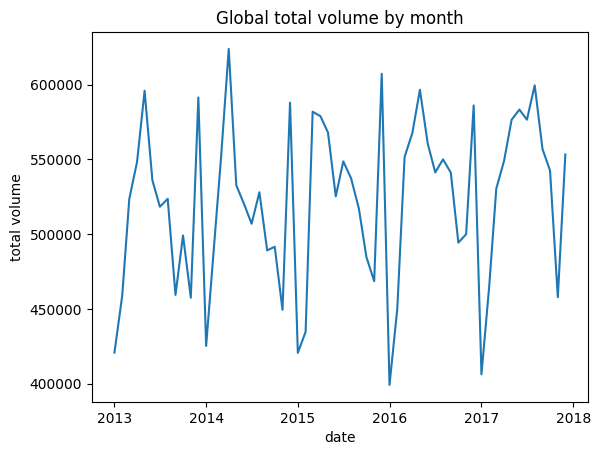

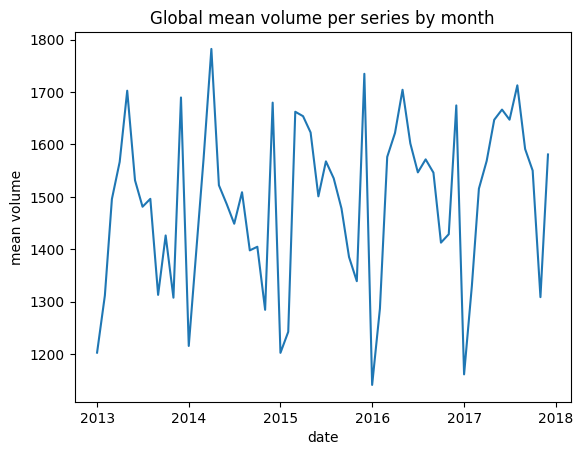

In [5]:

monthly_total = df.groupby(DATE_COL)[TARGET_COL].sum().sort_index()
monthly_mean = df.groupby(DATE_COL)[TARGET_COL].mean().sort_index()

plt.figure()
plt.plot(monthly_total.index, monthly_total.values)
plt.title("Global total volume by month")
plt.xlabel("date")
plt.ylabel("total volume")
plt.show()

plt.figure()
plt.plot(monthly_mean.index, monthly_mean.values)
plt.title("Global mean volume per series by month")
plt.xlabel("date")
plt.ylabel("mean volume")
plt.show()


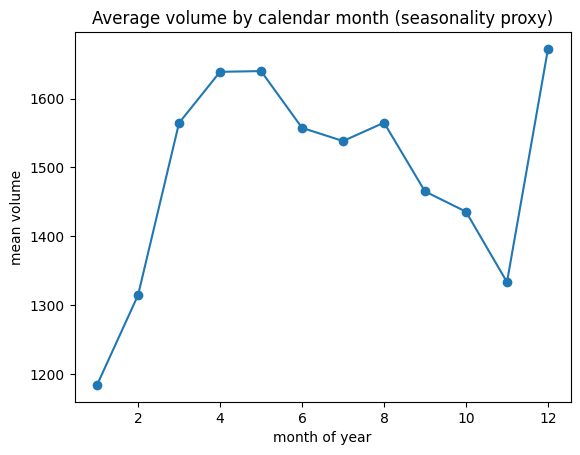

In [6]:

seasonality_by_month = df.groupby("month")[TARGET_COL].mean().sort_index()

plt.figure()
plt.plot(seasonality_by_month.index, seasonality_by_month.values, marker="o")
plt.title("Average volume by calendar month (seasonality proxy)")
plt.xlabel("month of year")
plt.ylabel("mean volume")
plt.show()


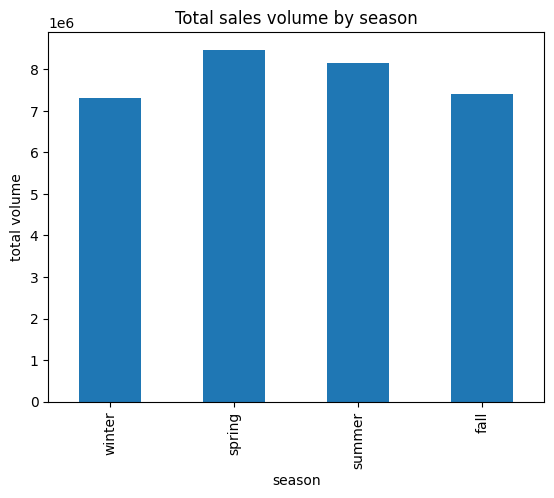

In [7]:

season_map = {
    12: "winter", 1: "winter", 2: "winter",
    3: "spring", 4: "spring", 5: "spring",
    6: "summer", 7: "summer", 8: "summer",
    9: "fall", 10: "fall", 11: "fall"
}
df["season"] = df["month"].map(season_map)

plt.figure()
df.groupby("season")[TARGET_COL].sum().reindex(["winter","spring","summer","fall"]).plot(kind="bar")
plt.title("Total sales volume by season")
plt.xlabel("season")
plt.ylabel("total volume")
plt.show()



### Series-level validation


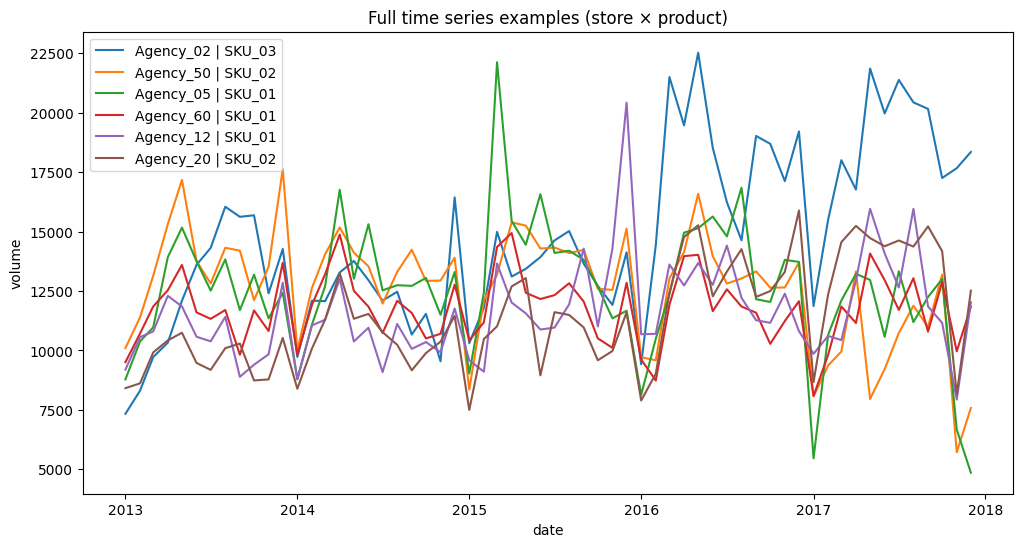

In [8]:

sample_series = (
    df.groupby([STORE_COL, PRODUCT_COL])[TARGET_COL]
      .sum()
      .sort_values(ascending=False)
      .head(6)
      .index
)

plt.figure(figsize=(12, 6))
for store, sku in sample_series:
    tmp = df[(df[STORE_COL] == store) & (df[PRODUCT_COL] == sku)].sort_values(DATE_COL)
    plt.plot(tmp[DATE_COL], tmp[TARGET_COL], label=f"{store} | {sku}")

plt.title("Full time series examples (store × product)")
plt.xlabel("date")
plt.ylabel("volume")
plt.legend()
plt.show()


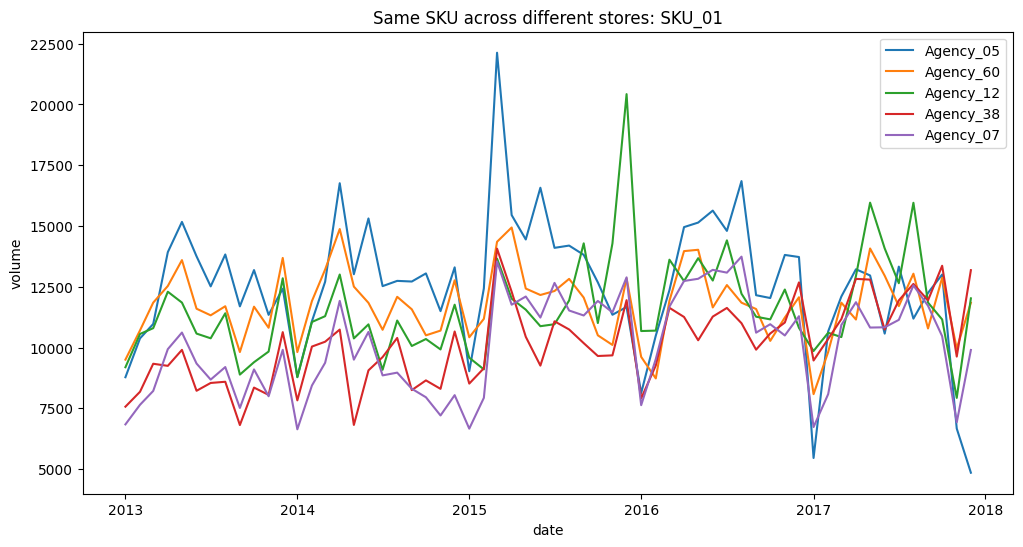

In [9]:

sku_focus = (
    df.groupby(PRODUCT_COL)[TARGET_COL]
      .sum()
      .sort_values(ascending=False)
      .index[0]
)

top_stores = (
    df[df[PRODUCT_COL] == sku_focus]
    .groupby(STORE_COL)[TARGET_COL]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

plt.figure(figsize=(12, 6))
for store in top_stores:
    tmp = df[(df[STORE_COL] == store) & (df[PRODUCT_COL] == sku_focus)].sort_values(DATE_COL)
    plt.plot(tmp[DATE_COL], tmp[TARGET_COL], label=store)

plt.title(f"Same SKU across different stores: {sku_focus}")
plt.xlabel("date")
plt.ylabel("volume")
plt.legend()
plt.show()



## 5) Data quality checks (what will break production)

We verify:
- missing values
- duplicates on (store, product, date)
- date parsing anomalies
- sanity checks on numeric features (negatives, impossible values)


In [10]:

# Missing values
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing_counts / len(df) * 100).round(3)
missing_summary = pd.DataFrame({"missing_n": missing_counts, "missing_%": missing_pct})
display(missing_summary[missing_summary["missing_n"] > 0])

# Duplicates
dup_mask = df.duplicated(subset=series_keys + [DATE_COL], keep=False)
print("Duplicate rows on (store, product, date):", int(dup_mask.sum()))

# Bad dates
print("Rows with unparseable dates:", int(df[DATE_COL].isna().sum()))

# Numeric sanity checks (negatives)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
negatives = {c: int((df[c] < 0).sum()) for c in num_cols}
neg_cols = {c:v for c,v in negatives.items() if v > 0}
print("Columns with negative values:", neg_cols)

# Business logic examples (adapt based on domain)
if {"price_actual","price_regular"}.issubset(df.columns):
    n_bad = int((df["price_actual"] > df["price_regular"]).sum())
    print("Rows with price_actual > price_regular:", n_bad, "(could be data issue or surcharge / dynamic pricing)")

if "discount_in_percent" in df.columns:
    print("discount_in_percent > 50%:", int((df["discount_in_percent"] > 50).sum()))
    print("discount_in_percent > 100%:", int((df["discount_in_percent"] > 100).sum()))
    display(df.loc[df["discount_in_percent"] > 100, [STORE_COL, PRODUCT_COL, DATE_COL, TARGET_COL, "price_regular", "price_actual", "discount_in_percent"]].head())


,missing_n,missing_%


Duplicate rows on (store, product, date): 0
Rows with unparseable dates: 0
Columns with negative values: {'price_actual': 1}
Rows with price_actual > price_regular: 53 (could be data issue or surcharge / dynamic pricing)
discount_in_percent > 50%: 102
discount_in_percent > 100%: 1


,agency,sku,date,volume,price_regular,price_actual,discount_in_percent
18686,Agency_46,SKU_17,2017-06-01,0.0852,2463.06338,-3121.690141,226.740147



## 6) Modeling implications (explicit hypotheses + recommended preprocessing)

This section turns EDA into **decisions**:
- what we assume about data generating process
- how we will preprocess & validate
- how we handle zeros/outliers
- what we exclude / segment (if needed)



### Key factual checkpoints from this dataset

- Panel completeness: **350 series**, each with **60 months** (no missing months found).
- Global zero rate: **12.15%**; median series has **0% zeros** but tail exists (intermittent series).
- Long dormancy: **54 series** have ≥12 consecutive zero months; **49 series** have ≥24.
- Heavy tail: target skewness ≈ **2.65**; p99 is very high → outlier-aware training/metrics.
- Spikes: **72 series** flagged with IQR-based spikes (**289 points**).
- No duplicate keys: duplicates on (store, product, date) = **0**.
- Price/discount anomalies: `price_actual` has **1** negative value, and **1** discounts > 100% (invalid).


In [11]:

# (Optional) simple baselines for sanity, not heavy modeling.
# We evaluate on the last 4 months globally: 2017-09 to 2017-12
# Baseline A: last observed value (carry-forward)
# Baseline B: seasonal naive (same month previous year)

df_sorted = df.sort_values([STORE_COL, PRODUCT_COL, DATE_COL]).copy()
all_months = pd.date_range(df_sorted[DATE_COL].min(), df_sorted[DATE_COL].max(), freq="MS")

test_months = all_months[-4:]
cutoff = all_months[-5]  # last train month

test_mask = df_sorted[DATE_COL].isin(test_months)
train_mask = df_sorted[DATE_COL] <= cutoff

last_train = df_sorted[train_mask].groupby([STORE_COL, PRODUCT_COL])[TARGET_COL].last()
pred_last = df_sorted[test_mask].set_index([STORE_COL, PRODUCT_COL]).index.map(last_train).astype(float)

# seasonal naive (lag 12 months)
df_sorted["date_lag12"] = df_sorted[DATE_COL] - pd.DateOffset(years=1)
lag_map = df_sorted.set_index([STORE_COL, PRODUCT_COL, DATE_COL])[TARGET_COL]

pred_season = []
for _, row in df_sorted[test_mask].iterrows():
    pred_season.append(lag_map.get((row[STORE_COL], row[PRODUCT_COL], row["date_lag12"]), np.nan))
pred_season = np.array(pred_season, dtype=float)

y_true = df_sorted.loc[test_mask, TARGET_COL].astype(float).values

def smape(y, yhat, eps=1e-9):
    denom = (np.abs(y) + np.abs(yhat) + eps)
    return np.mean(2 * np.abs(yhat - y) / denom)

def wape(y, yhat, eps=1e-9):
    return np.sum(np.abs(yhat - y)) / (np.sum(np.abs(y)) + eps)

def metrics(y, yhat):
    mask = ~np.isnan(yhat)
    y2, yhat2 = y[mask], yhat[mask]
    return {
        "coverage": float(mask.mean()),
        "MAE": float(np.mean(np.abs(yhat2 - y2))),
        "RMSE": float(np.sqrt(np.mean((yhat2 - y2) ** 2))),
        "sMAPE": float(smape(y2, yhat2)),
        "WAPE": float(wape(y2, yhat2)),
    }

m_last = metrics(y_true, pred_last.values)
m_season = metrics(y_true, pred_season)

display(pd.DataFrame([m_last, m_season], index=["last_value", "seasonal_naive"]))


,coverage,MAE,RMSE,sMAPE,WAPE
last_value,1.0,320.145162,828.105003,0.439219,0.212343
seasonal_naive,1.0,314.085553,802.337684,0.561776,0.208324



## Perspectives (out of scope)

Potential next steps:
- Store-level aggregation and clustering
- Assortment depth effects
- Static embeddings for TFT / TSMixer

Deferred intentionally to keep EDA concise and modeling-oriented.



## 7) Conclusions synthétiques (to copy into README)

### Key EDA Findings (max 10)
- Dataset size: **21,000 rows**, **26 columns**; identifiers: **58 stores (agency)** × **25 products (sku)** → **350 series**.
- Temporal scope: **2013-01-01 → 2017-12-01**, **monthly strict** (100% at month start), **60 unique months**.
- Panel is complete: **every series has 60 months** and **0 missing months** (no gaps), which simplifies feature engineering and backtesting.
- Target is heavy-tailed (skewness ≈ **2.65**): large outliers exist (p99 far above median), so robust loss/metrics are needed.
- Zeros exist but are not dominant globally (**12.15%** overall); however intermittency is concentrated in a subset of series.
- Dormant/intermittent demand: **54 series** have ≥12-month zero streaks (**49** have ≥24), suggesting separate handling (e.g., intermittent models or classification+regression).
- Abnormal spikes flagged: **72 series** with IQR-based spikes (**289 points**), consistent with promos/stock effects or data issues.
- Data quality is mostly clean on keys: **0 duplicates** on (store, product, date), **0 unparseable dates**.
- A few feature anomalies exist (e.g., **1** negative `price_actual`, **1** `discount_in_percent` > 100%) → must be sanitized for production.

### Modeling Implications
- Because the panel is complete and monthly, use a **global model** (single model across series) with entity IDs as categorical features or embeddings; no need for gap-filling.
- Prefer evaluation metrics robust to heavy tails and zeros (e.g., **WAPE/MAE**; be cautious with MAPE on zeros).
- Consider **segmentation**: “regular demand” vs “intermittent/dormant” series; dormant series may need different objectives (e.g., probability of non-zero + magnitude).
- Outlier strategy must be explicit (winsorization per series, robust loss, or promo-aware features like discount/holidays).
- Use a time-based split with the final 4 months as a realistic horizon; naive baselines achieve roughly **WAPE ≈ 0.212 (last value)** and **0.208 (seasonal)** as a minimum bar.

### Data Limitations & Risks
- Target likely impacted by promotions/price events; if these covariates shift in the future, forecasts may degrade (covariate shift risk).
- Intermittent/dormant series can dominate relative-error metrics; metric choice must match business objective (avoid zero-div issues).
- Feature anomalies (negative prices, >100% discount) indicate potential upstream data issues; production pipelines must include validation rules and quarantine logic.
